<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Vadim Voskresenskii, Vadimvoskresenskiy
    
## <center> Predicting successful projects on Kickstarter

### Part 1. Dataset and features description

Before diving into the data analysis and features engineering, let me introduce you to the context of current project. In the project, I am working with data taken from online [platform Kickstarter](https://www.kaggle.com/kemical/kickstarter-projects). This platform was created specially for crowdfunfing, and any person (or group of persons) can publish idea of any project on it and expect that some interested users of the platform will fund this idea. Usually, funders get some exclusive prizes from creators, and the size of the prize depends on how much money you put into the project. Obviously, not all the projects have a success and get enough money. Therefore, predicting those features which make projects successful becomes very important purpose for data analysts. Well-working models can be very helpful instruments for those innovators who want to try their luck with getting money on the platform.

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy import stats
import math
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

So, now let's upload the data and look at it's contents. 

In [12]:
df = pd.read_csv('ks-projects-201801.csv')

In our dataset, we have 15 variables and 378661 observations.

In [13]:
df.shape

(378661, 15)

Let me describe the variables in the dataset.

*ID* - not significant variable for us which just corresponds to unique number of a project.

*name* - name of the project

*category* - subcategory

*main_category* - broad category to which the current project is related

*currency* - currency in which payments need to be implemented

*deadline* - date after which payments are not acepted anymore

*goal* - money needed for realization of a project

*launched* - when project was launched

*pledged* - how much people funded

*state (target variable)* - what is going on finally with the project after deadline (whether it's failed, canceled or successful)

*backers* - how many people funded the project

*country* - country of project's creators

*usd_pledged* - how much paid by backers (conversed to USD)

*usd_pledged_real* - how much paid by backers (conversed to USD by another app)

*usd_goal* - goal (conversed to USD)

In [14]:
df.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Part 2-3. Exploratory and visual data analysis

First of all, before looking at dependencies between variables I have to consider distributions of features and target variable.

Let's start with target variable. Which values does it include?

In [15]:
df['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

So, we can see that apart from failed and successful projects, we also have canceled, live, undefined and suspended ones. Let's look how our projects are distributed among these categories.

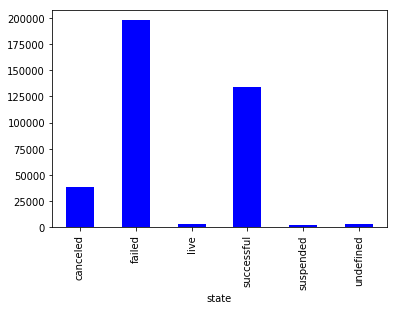

In [16]:
df.groupby('state').size().plot(kind='bar', color = "blue")

Most of the data is related to categories 'failed' and 'successful'. Also, we can see that our data is imbalanced a bit; we have more failed projects than successful ones.

Let's leave only failed and successful projects. 

In [17]:
df = df[df['state'].isin(['failed', 'successful'])]
df.shape

(331675, 15)

Now let's move to our features.

First, it's interesting to check which categories are the most popular on Kickstarter.

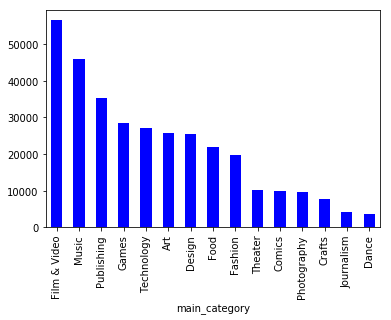

In [18]:
df.groupby('main_category').size().sort_values(ascending = False).plot(kind='bar', color = "blue")

We can see that projects related to categories Films & Video make the biggest part of all projects in our dataset. 

With help of column representing subcategories, we can see which types of projects are included in the category.

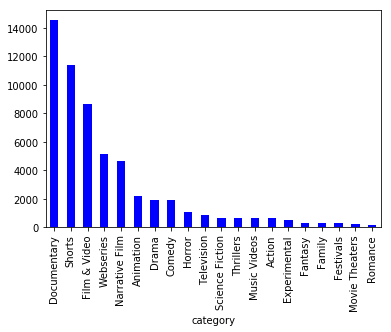

In [20]:
df[df.main_category == 'Film & Video'].groupby('category').size().sort_values(ascending = False).plot(kind='bar', color = "blue")

Ok, it seems that most of the projects in the category Films & Video need some money for sponsorship of documentaries and short films. At the same time, we observe that approximately 8000 films are not related to any subcategory and tagged as Film & Video. 

What's going on with the countries. From which countries do the projects come?

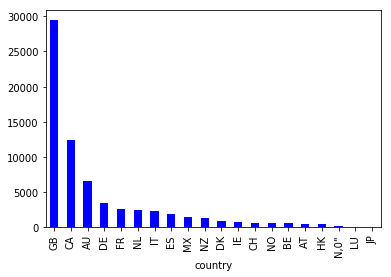

In [21]:
df.groupby('country').size().head(20).sort_values(ascending = False).plot(kind='bar', color = "blue")

If we look at the 20 the most popular countries, we would see that Great Britain is undisputed leader, and most of the projects are coming exactly from this country.

Now, let's look how our numerical variables are distributed. Let's start with number of backers. For the visualization, I took logarithm for number of backers as we have very strong outliers in this variable, and all small values are compressed in the bottom of the chart. 

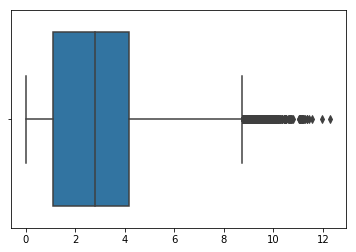

In [22]:
sns.boxplot(np.log(np.array(df['backers']) +1))

According to the boxplot, we can see that we have some rare projects having more than 200000 backers, whereas the median for our real (non-logarithmic) distribution is 15. 

How do the boxplots for goals and pledged money look like? For these features, I took the variables already conversed to USD.

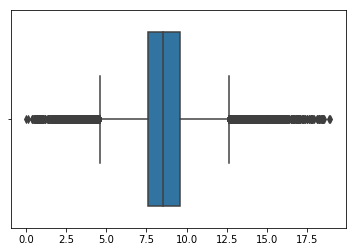

In [23]:
sns.boxplot(np.log(np.array(df['usd_goal_real']) +1))

Distribution of log-scaled goal is very close to normal one where real median value is 5000 USD. And in this case, we have outliers from both sides of our boxplot.

So, now we know some information on our independent and dependent variables, and we can move to more interesting part of EDA where we are going to study relationships between these variables.

First of all, let's study which categories have more success in terms of funding.

Before visualizing patterns, I am going to count continguency chi2 test to check if there any statisitcally siginificant connection between observed variables. In the case of chi2 test, null hypothesis says that categorical variables are independent from each other, whereas alternative hypothesis claims that these variables are interconnected. 

In [25]:
def chi2_output(x, y):
    results = stats.chi2_contingency(pd.crosstab(x, y))
    return "X2: {0}, p-value: {1}, degrees of freedom: {2}".format(results[0], results[1], results[2])

In [26]:
chi2_output(df.state, df.main_category)

'X2: 15455.435709922263, p-value: 0.0, degrees of freedom: 14'

So, p-value = 0, and it means we can reject null hypothesis and say that our variables are interconnected.

To look in details how the variables are interconnected, I will write function which counts Pearson residlas (standardized difference between observed and expected values) and draws heatmap on the base of them. 

In [27]:
def pearson_heatmap(x, y):
    crosst = pd.crosstab(x, y)
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosst)
    pears_failed = (crosst.iloc[0,:] - ex[0])/np.sqrt(ex[0])
    pears_success = (crosst.iloc[1,:] - ex[1])/np.sqrt(ex[1])
    return sns.heatmap(pd.concat([pears_failed, pears_success], axis=1), annot=True,
                fmt=".1f",
                annot_kws={'size':10})

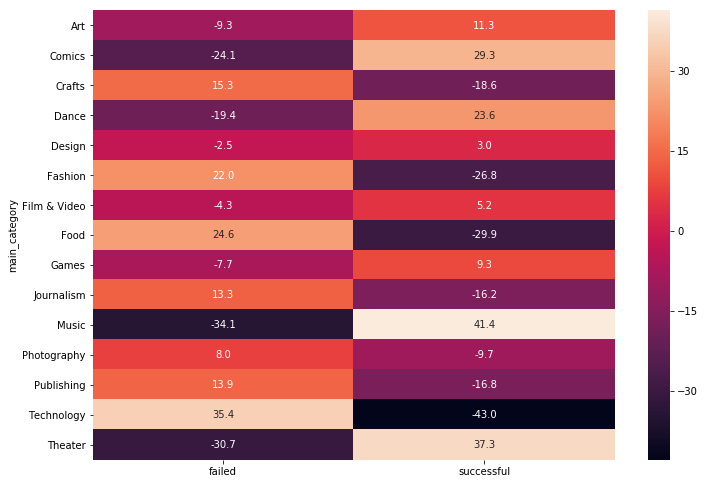

In [28]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
pearson_heatmap(df.state, df.main_category)

We can see some interesting patterns from this heatmap. Projects related to categories Theater, Music and Comics have high chances to get enough funding. At the same time, projects from Food, Fashion, and, especially, Technology more often fail. Probably, it can be explained by that these projects need more money. Let's check that.

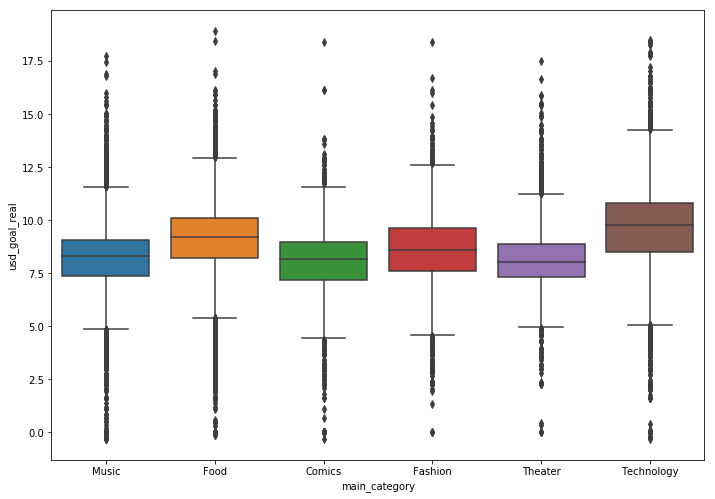

In [29]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
df_comp = df[df.main_category.isin(['Technology', 'Food', 'Fashion', 'Music', 'Comics', 'Theater'])]
sns.boxplot(df_comp["main_category"], np.log(df_comp['usd_goal_real']))

We can, certainly, see that median goal value for Technology is higher than for other categories.

What if we look at the subcategories of two the most popular categories in our dataset (Films & Video and Music).

In [30]:
chi2_output(df.state, df.category[df.main_category == "Film & Video"])

'X2: 2252.260163153181, p-value: 0.0, degrees of freedom: 19'

Ok, the relationship is statisitcally significant.

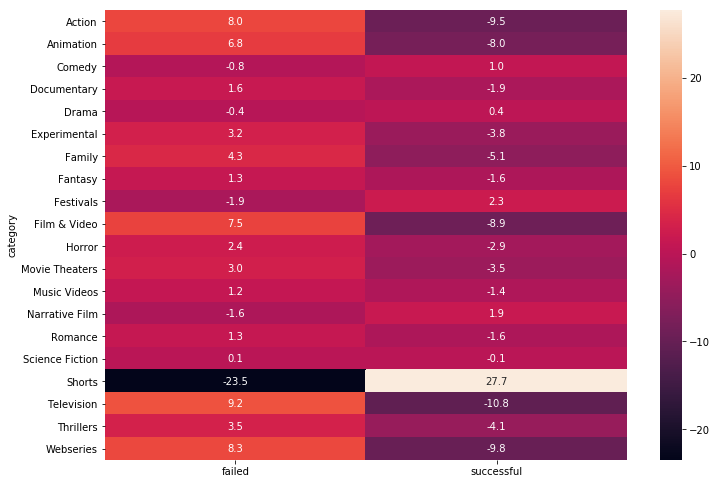

In [31]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
pearson_heatmap(df.state, df.category[df.main_category == "Film & Video"])

Aha! If you are making short film, you will probably get enough money.

What's about music?

In [32]:
chi2_output(df.state, df.category[df.main_category == "Music"])

'X2: 3305.884109743846, p-value: 0.0, degrees of freedom: 18'

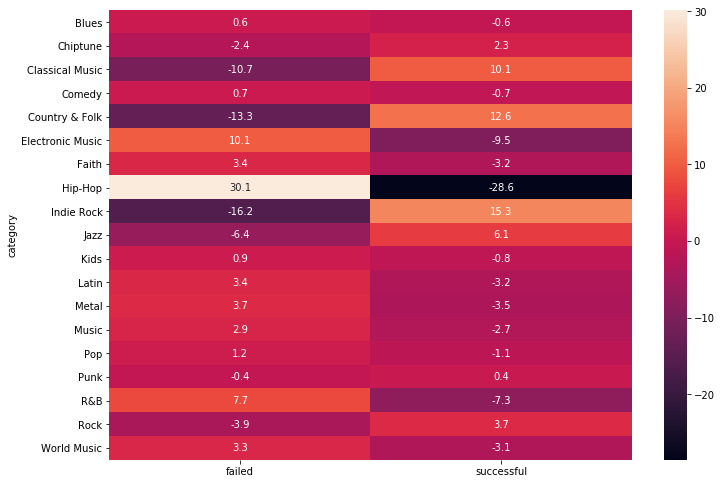

In [33]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
pearson_heatmap(df.state, df.category[df.main_category == "Music"])

Don't ask for financial help to make hip hop album, it's easier to get enough funding if you are indie, classical or country musiciant.

Let's look how a success/failure of a project changes depending on originating country.

In [34]:
chi2_output(df.state, df.country)

'X2: 2207.9085420347137, p-value: 0.0, degrees of freedom: 22'

Variables are interconnected.

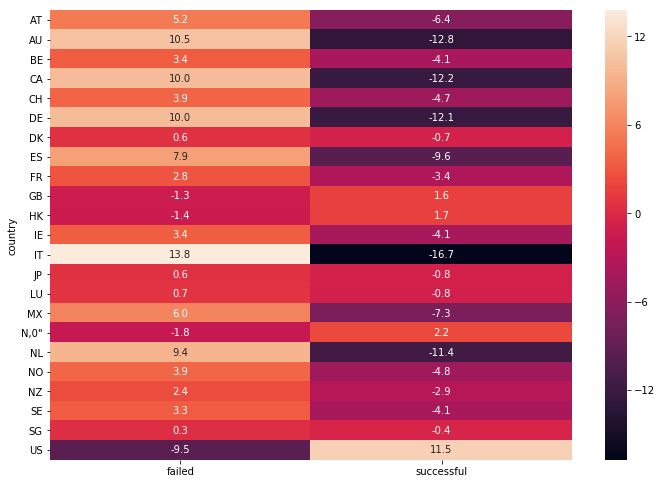

In [35]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
pearson_heatmap(df.state, df.country)

The most successful projects come from United States, while Italian projects often do not get enough funding.

Let's see how our target variable interacts with numeric independent variables. We start with goal.

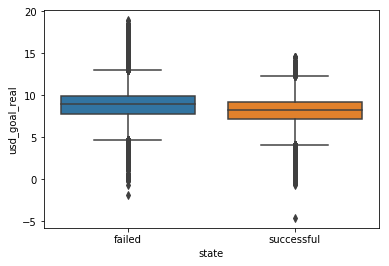

In [36]:
sns.boxplot(df["state"], np.log(df['usd_goal_real']))

As expected, failed projects have higher median goal.

What's about backers?

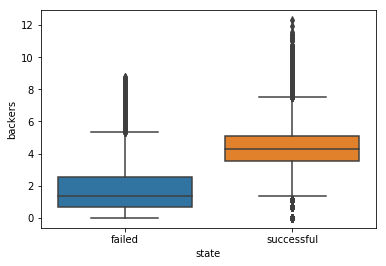

In [37]:
sns.boxplot(df["state"], np.log(df['backers'] + 1))

Aha, it should be good feature for future model. Successful projects have more backers.

### Part 4. Patterns, insights, pecularities of data 

As we can see from exploratory data analysis there some interesting relationships of our potential features and target variable (success of a project).

1. Presumably, one of the most important features in our future model will be the category to which a project is related. Due to applied statisitcal tests and drawn heatmaps, we can see that not all categories have equal chances to get enough financial support. 

2. Moreover, we found strong differentiation inside categories. For instance, the better strategy to raise enough money in category Film & Video is to make short movies, and if you are making hip hop music, you have lower chances to collect enough resources than people creating indie rock, classical or folk music. 

3. Also, we do not need to forget about the origin country of a project. Whether project comes from Italy or United States can be one of the key factor explaining success of a project. I think it's connected directly with popularity of platform in the countries. 

4. Also, after exploratory analysis we have some information about financial characteristics of successful projects. According to our analysis, successful projects have more backers and lower goals. It's obvious finding but, anyway, it can be useful predictor in our model.

### Part 5. Data preprocessing

First of all, we need to transform our categorical variables which we are going to use (category, main_category, country) in the final model into dummy variables. 

In [38]:
dummies = pd.get_dummies(df.iloc[:, [2,3,11]])
dummies.shape

(331675, 197)

Now, we have 197 columns with all categories and subcategories.

What's about numeric variables? On the base of our exploratory analysis, we can conclude that variables # of backers and goal in USD can be very important features in our model. Let's add them to dummy variables.

And we need our target variable State which will be transformed into binary format where 0 stands for failure and 1 stands for success.

In [39]:
y = df['state'].map({'successful': 1, 'failed': 0}).values
model_df = pd.concat([dummies, df.iloc[:,[10,14]]], axis = 1)

### Part 6. Feature engineering and description 

One of the interesting features can be made on the base of variables showing when a project was launched and what is a deadline for a project. I hypothesize that projects having longer period between launching and deadline have more chances to become successful. Thereby, let's create feature showing how many days are between these two important dates.

In [40]:
df['days_diff'] = (pd.to_datetime(df["deadline"])-pd.to_datetime(df["launched"])).astype('timedelta64[D]')
df['days_diff'].head()

0    58.0
1    59.0
2    44.0
3    29.0
5    34.0
Name: days_diff, dtype: float64

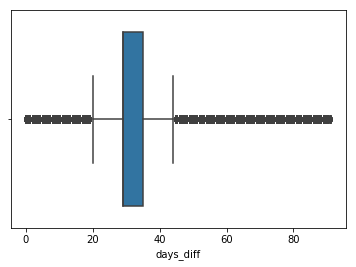

In [41]:
sns.boxplot(df['days_diff'])

Median value is 29. For some projects, the number of days between launching and deadline is 0, and it's strange. Out of sheer curiosity, let's check if there any successful projects among those ones having 0 days for funding.

In [46]:
df[(df['days_diff'] == 0) & (df['state'] == 'successful')].head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,days_diff
12494,1062718053,Interior Garden (1978),Film & Video,Film & Video,GBP,2016-06-15,130.0,2016-06-14 02:24:00,130.0,successful,12,GB,185.32,185.73,185.73,0.0
23300,1118279594,Poster: All 3D Printers Made,Art,Art,USD,2014-07-16,20.0,2014-07-15 15:20:08,20.0,successful,1,US,20.00,20.00,20.00,0.0
34578,1175306310,Björk Swan Dress T-Shirt,Conceptual Art,Art,USD,2012-02-17,180.0,2012-02-16 17:56:27,472.0,successful,45,US,472.00,472.00,180.00,0.0
65731,1334283643,Freshman Survival Guide,Publishing,Publishing,USD,2012-03-31,50.0,2012-03-30 22:11:20,70.0,successful,2,US,70.00,70.00,50.00,0.0
70685,1359826889,"""Insert Title Here"" a 24 hour comic day comic",Comics,Comics,USD,2016-10-02,20.0,2016-10-01 00:28:42,49.0,successful,7,US,49.00,49.00,20.00,0.0


Wow! They really exist!

Also, it's a bit strange that some projects have duration more than 60 days, as, according to official website of Kickstarter projects can last from 1 to 60 days. Probably, they are old projects whcih were launched when requirements differed.

Let's look how new feature is connected with our target variable.

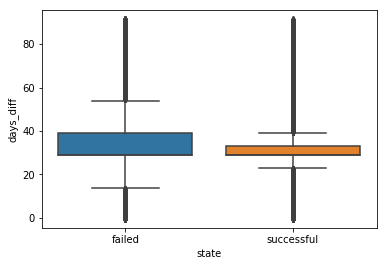

In [43]:
sns.boxplot(df["state"], df['days_diff'])

In [47]:
df.groupby('state')['days_diff'].median()

state
failed        29.0
successful    29.0
Name: days_diff, dtype: float64

For both types of projects, median value is 29. It's not surprizing as the official recommendation from Kickstarter is to set a campaign at 30 days or less, as 'campaigns with shorter durations have higher success rates, and create a helpful sense of urgency around your project'.

This chart, to some extent, supports this claim. Despite of the presence of equal medians for failed and successful projects, we can see that among failed ones there are more long-lasting campaigns. Therefore, this feature should be added to our model.

Another possibly useful feature could be connected with variables # of backers and final goal of a project. What if we look how much one backer needs to put into a project. Let's imagine that we have two projects. Both need to get 15000 $, but in the first project only 10 backers participate, while in the second one there are 60 backers. Clearly, the second project has higher chances to get needed money.

In [48]:
df["usd_by_backer"] = df["usd_goal_real"] / (df["backers"] + 1)

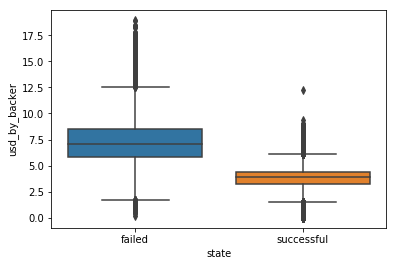

In [49]:
sns.boxplot(df["state"], np.log(df['usd_by_backer'] + 1))

Yes, as I supposed in failed projects each person needs to submit more money comparing to successful projects.

Now, we can add new features to our dataset.

In [50]:
model_df = pd.concat([model_df, df.iloc[:,[15,16]]], axis = 1)

In [108]:
X_train, X_test, y_train, y_test = \
    train_test_split(model_df, y, 
                     test_size=0.3, random_state=2)

As we have very different scales of our variables, we need to rescale them.

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Part 7. Cross-validation, hyperparameter tuning

Ok, now we need to define hyperparameters we are going to use in our model and by applying cross-validation choose one which gives better results.

First of all, what's the model I am going to use in the project? Logistic regression fits our task well. We have a big number of features, and in this case Random Forests would give worse accuracy than Logistic Regression.

As we have a big number of features and the issue of overfitting is very dangerous for our model, we need to find the best hyperparameter C. This hyperparameter is responsible for regularization of the model. C penalizes features which have large values in model and minimizes error. Thereby, it allows researcher to reduce chances to get overfitted mode which works well only with training set, while in the case of test data it gives rather poor results.

For evaluating the quality of our model, we will be using ROC-AUC score. The idea of ROC curve is to visualize true positive predicitions (in our case, those successful projects which were classified correctly) against false positive prediction (those projects which were classified as successful ones by mistake).

For checking our measures, we will use stratified cross-validation. In the case of stratified cross-validation, our sample is divided in some folds in which all classes we predict are distributed equally (it means that in each fold, we have nearly half of successful and nearly half of failed projects).

In [55]:
lr = LogisticRegression(random_state=2, solver='liblinear')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
Cs = np.logspace(-3, 1, 10)
reg_params = {'C': Cs}
grid_search = GridSearchCV(lr, reg_params, n_jobs=-1, scoring ='roc_auc', cv=skf)
grid_search.fit(X_train_scaled, y_train)

c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=2, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 2.78256e-03, 7.74264e-03, 2.15443e-02, 5.99484e-02,
       1.66810e-01, 4.64159e-01, 1.29155e+00, 3.59381e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Ok, we see that C which equals to 10 gives the best ROC-AUC. It's a bit contentious case as 10 is the border value in our list, and, probably, higher values would give better results. 

In [59]:
grid_search.best_params_, grid_search.best_score_

({'C': 10.0}, 0.9467790038544053)

### Part 8. Validation and learning curves

Let's draw our validation curve. I will do that without gridsearch to fasten the process a bit.

In [69]:
def get_auc_lr_valid(X, y, C=1.0, seed=2,ratio = 0.9):
    idx = int(round(X.shape[0] * ratio))
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    score = roc_auc_score(y[idx:], y_pred) 
    return score

In [103]:
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train_scaled, y_train, C=C))


 40%|█████████████████████████████████▏                                                 | 4/10 [01:43<02:45, 27.55s/it]c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)

 50%|█████████████████████████████████████████▌                                         | 5/10 [02:29<02:45, 33.15s/it]c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:31<02:46, 41.71s/it]c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)

 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:07<02:53, 57.92s/it]c:\user

c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


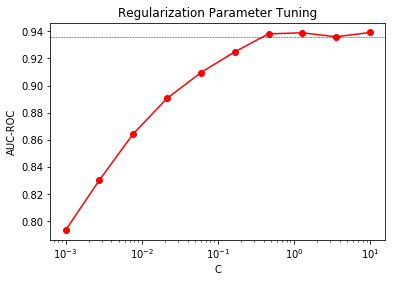

In [104]:
score_C_1 = get_auc_lr_valid(X_train_scaled, y_train)
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 
plt.show()

So, we can see here interesting picture. We have two values which give maximum ROC AUCs on X axis: 1 and 10. Probably, we need to take C=1 as the C=10 can lead to overfitting of the model. Let's check that on our test sample.

### Part 9. Prediction for hold-out and test samples 

Now, we can look how our model predicts test set. As the situation with measure of C was not clear after drawing ROC-AUC scores, we will make two predictions: the first one with C=10 and the second one with C=1.

In [122]:
lr = LogisticRegression(C=10, random_state=2, solver='liblinear').fit(X_train_scaled, y_train)

c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [125]:
y_pred10 = lr.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_pred) 

c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.9429440470933312

In [119]:
lr = LogisticRegression(C=1, random_state=2, solver='liblinear').fit(X_train_scaled, y_train)

c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [121]:
y_pred1 = lr.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_pred) 

c:\users\vadim\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.9426617400025494

Ok, we have very close results but C=10 gives a bit better accuracy.

### Part 10. Model evaluation with metrics description

Let's look at two main metrics for binary classification: precision and recall.

- Recall shows share of True Positives out of all instances which have to be classified as True Positives (but some of them were classified as Negatives).

- Precision shows which share of True Positives against all instances which were classified as Positives (but some of them are Negatives in reality). 

In our case, Precision will show how many projects classified as successful are really successful and how many of them are failed ones.  Recall will show how well our model predicts successful proejcts and how many of them were misclassified as failed ones. 

In the following outcome you can see aforementioned measures counted for successful projects.

In [154]:
y_pred = lr.predict(X_test_scaled)
print("Precision:{}".format(precision_recall_fscore_support(y_test, y_pred)[0][1]))
print("Recall:{}".format(precision_recall_fscore_support(y_test, y_pred)[1][1]))
print("F1:{}".format(precision_recall_fscore_support(y_test, y_pred)[2][1]))

Precision:0.9012382250133302
Recall:0.759802207681934
F1:0.8244986449864498


In this result, the first row stands for precision, the second one stands for recall and the third one for F1 score which tries to show balanced measure between precision and recall.

So, we see that our model is not ideal and we make errors, but we definitely see that Precision works comparatively better than Recall in our model.  It means that our model more or less good in sorting out failed projects and it rarely classify them as successful ones, but, at the same time, it loses a lot of successful projects (~24%) and mark them as failed ones. 

### Part 11. Conclusions

In this project, I applied logistic regression to classify successful and failed projects on Kickstarter. Such model can be very useful instrument for potential crowdfunders as it allows them to choose better category for their project (for instance, it's better idea to raise money for short movie) and it can be used for setting optimal money goals.

At the same time, so far, the model is not perfect. It more or less well in defining failed projects and sort out them but it loses a big set of successful projects classifying them as failed ones. Definitely, this issue needs to be fixed: we need to better study characterisitcs of successful projects, work at new features for them and, probably, look at other classification algorithms. Also, this issue can be somehow related to disbalance in our target variable. So, the good way to improve final measures is to balance our instances.